In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

А. Будем добывать следующие характеристики треков в стиле техно:
    1. качество песни (соотношение среднего времени прослушивания трека к его длительности)
    2. популярность песни (количество прослушиваний за последний месяц) + составить топ-30
    (посмотреть корреляцию между популярностью и дослушиванием, просто интересно)

Б. Теперь про характеристики пользователей:
    1. как много слушает техно (соотношение количества прослушанных техно-треков к общему количеству прослушанных треков)
    2. насколько популярные песни слушает (количество треков из топ-30 в прослушанных за последний месяц треках)
    3. дослушивает ли песни? (соотношение среднего времени прослушивания трека к среднему времени прослушивания трека (А.1))
    
На основе этих характеристик пользователя составляется score для каждого из них. Ну и взять топ-N, так чтобы попадать в экономику =)

In [10]:
#Prepare Data
data = pd.read_csv("music_data.csv")
data_last_month = data[pd.to_datetime(data['utc_audition_end_dttm']) > (pd.to_datetime(data['utc_audition_end_dttm']).max() - pd.to_timedelta(30, unit='d'))]
techno_data = data[data["track_genre"]=="TECHNO"].copy()
techno_data_last_month = techno_data[pd.to_datetime(techno_data['utc_audition_end_dttm']) > (pd.to_datetime(techno_data['utc_audition_end_dttm']).max() - pd.to_timedelta(30, unit='d'))]
techno_data.columns

Index(['Unnamed: 0', 'audition_id', 'track_duration', 'track_genre',
       'track_id', 'user_id', 'utc_audition_end_dttm',
       'utc_audition_start_dttm'],
      dtype='object')

In [11]:
# Techno tracks' quality - l_time_to_t_duration -> track_quality

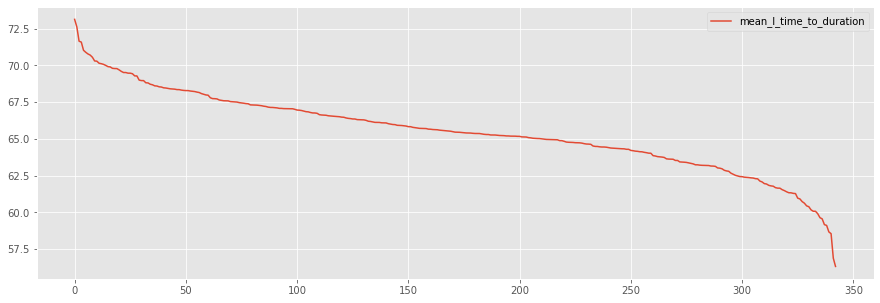

In [90]:
techno_data['l_time_to_t_duration'] = (pd.to_datetime(techno_data['utc_audition_end_dttm']) - pd.to_datetime(techno_data['utc_audition_start_dttm'])) / pd.to_timedelta(techno_data['track_duration'], unit='s') * 100.0
track_quality = techno_data[['track_id', 'l_time_to_t_duration']].groupby('track_id').mean().copy()
track_quality.columns = ['mean_l_time_to_duration']

track_quality.sort_values(by='mean_l_time_to_duration', ascending=False).reset_index(drop=True).plot()

In [79]:
# Techno tracks' population num_of_aouditions -> track_popularity (last month listened tracks only!)

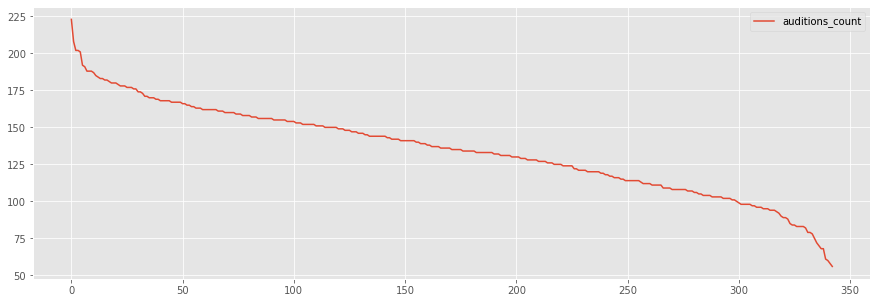

In [80]:
track_popularity = techno_data_last_month[['track_id', 'audition_id']].groupby('track_id').count().copy()
track_popularity.columns = ['auditions_count']

track_popularity.sort_values(by='auditions_count', ascending=False).reset_index(drop=True).plot()

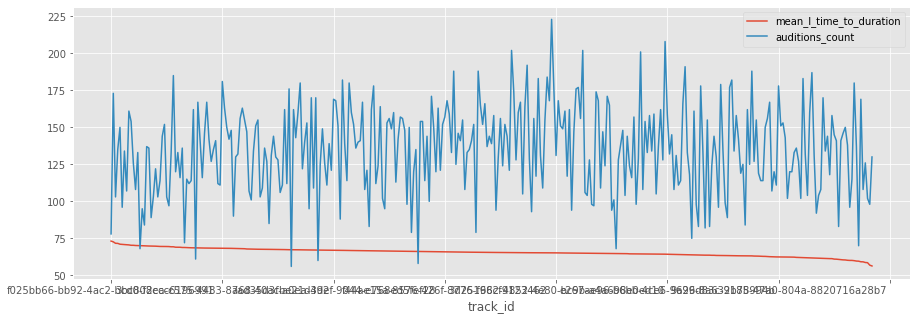

In [81]:
# see if quality and popularity are correlated - NO CORRELATION =)
view = track_quality.join(track_popularity, how='inner', on='track_id')
view.sort_values(by='mean_l_time_to_duration', ascending=False).plot()

In [82]:
# users' techno listening percentage -> user_techno_to_all_tracks

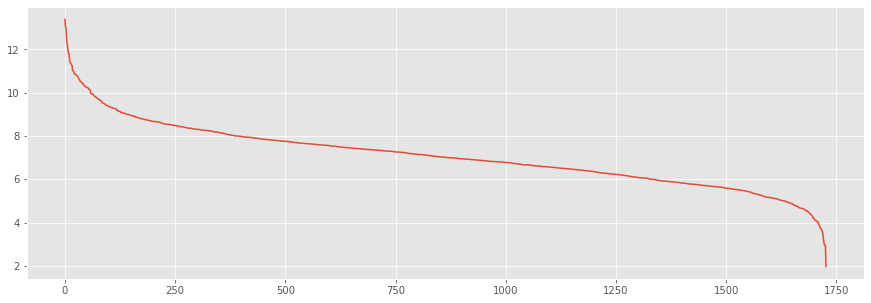

In [83]:
user_techno_tracks = techno_data_last_month[['user_id', 'audition_id']].groupby('user_id').count()
user_techno_tracks.columns = ['techno_count']
user_all_tracks = data_last_month[['user_id', 'audition_id']].groupby('user_id').count()
user_all_tracks.columns = ['all_count']

user_techno_all_tracks = user_techno_tracks.join(user_all_tracks, how='inner', on='user_id')
user_techno_all_tracks['techno_to_all_percent'] = user_techno_all_tracks['techno_count'] / user_techno_all_tracks['all_count'] * 100.0

user_techno_all_tracks.sort_values(by='techno_to_all_percent', ascending=False)['techno_to_all_percent'].reset_index(drop=True).plot()

In [84]:
# users' popular techno songs' percentage -> user_thirty_popular_percentage

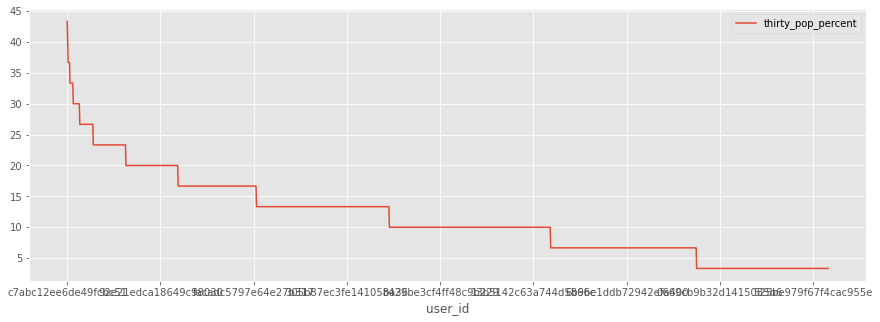

In [85]:
top_thirty = track_popularity.sort_values(by='auditions_count', ascending=False)[:30]
user_thirty_popular_percentage = techno_data_last_month.join(top_thirty, how='inner', on='track_id')[['user_id', 'track_id']].groupby('user_id').count()
user_thirty_popular_percentage.columns = ['thirty_pop_percent']

user_thirty_popular_percentage['thirty_pop_percent'] = user_thirty_popular_percentage['thirty_pop_percent'] / 30 * 100.0
user_thirty_popular_percentage.sort_values(by='thirty_pop_percent', ascending=False).plot()

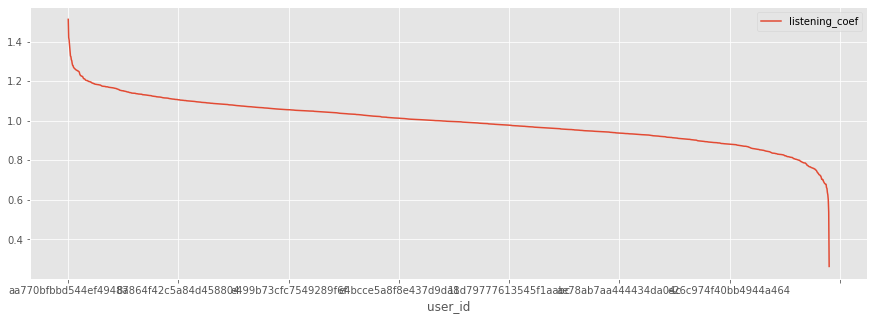

In [110]:
# users' audition duration coefficient -> users_listening_coef
users_audition_quality = techno_data_last_month.join(track_quality, how='inner', on='track_id')
techno_data_view = techno_data[['audition_id', 'l_time_to_t_duration']].set_index('audition_id', drop=True)
users_audition_quality = users_audition_quality.join(techno_data_view, how='inner', on='audition_id')
users_audition_quality['listening_coef'] = users_audition_quality['l_time_to_t_duration'] / users_audition_quality['mean_l_time_to_duration']
users_audition_quality = users_audition_quality[['user_id', 'listening_coef']].groupby('user_id').mean()
users_audition_quality.sort_values(by='listening_coef', ascending=False).plot()

In [111]:
# now scoring goes in!
# ...
# and add normalize values, please!
#составляющие нормализуем, а все целиком - нет. Веса - в 1, потом можно подумать над ними